In [5]:
#!pip install celltypist
import celltypist
from celltypist import models
import scanpy as sc

In [6]:
####Gut single cell atlas

file_path = '/Users/lingting/Documents/GVHD_project/FromJessie/Tcell_raw_counts02_v2.h5ad'
adata = sc.read_h5ad(file_path)

print(adata)
adata = adata[adata.obs['Diagnosis'] == 'Healthy adult', :]

AnnData object with n_obs × n_vars = 38633 × 33538
    obs: 'Sample name', 'Diagnosis', 'Age', 'sample name', 'Region code', 'Fraction', 'Region', '10X', 'batch', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'doublet_scores', 'predicted_doublets', 'S_score', 'G2M_score', 'phase', 'productive', 'annotation', 'Gender'
    var: 'gene_ids', 'feature_types'


In [7]:
adata.X.max()

15107.0

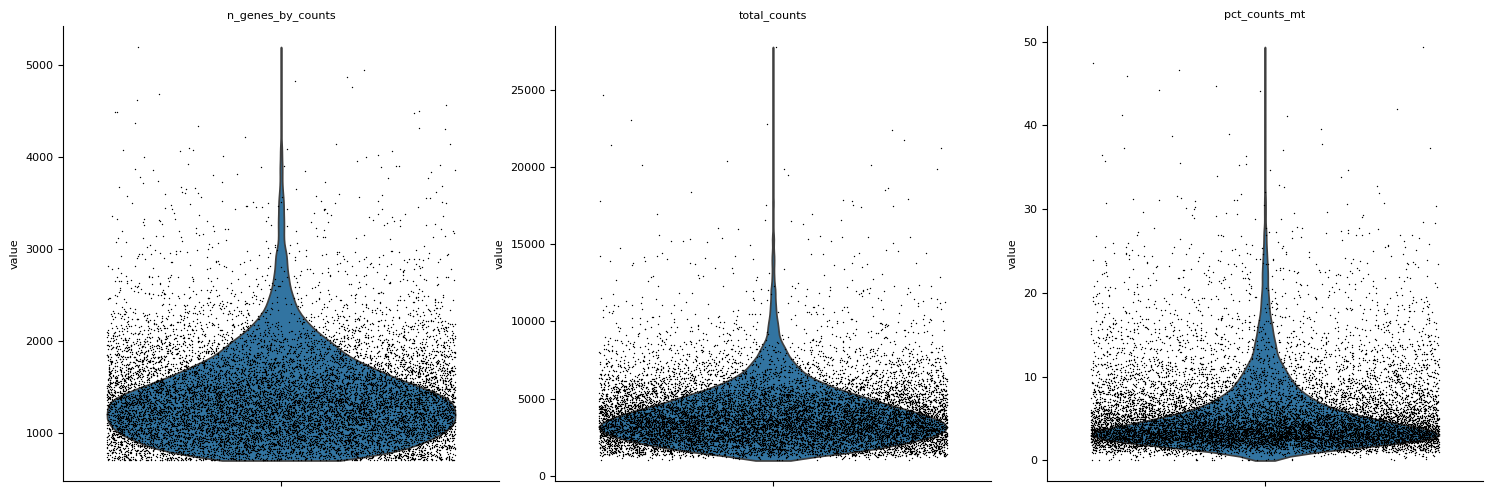

In [8]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

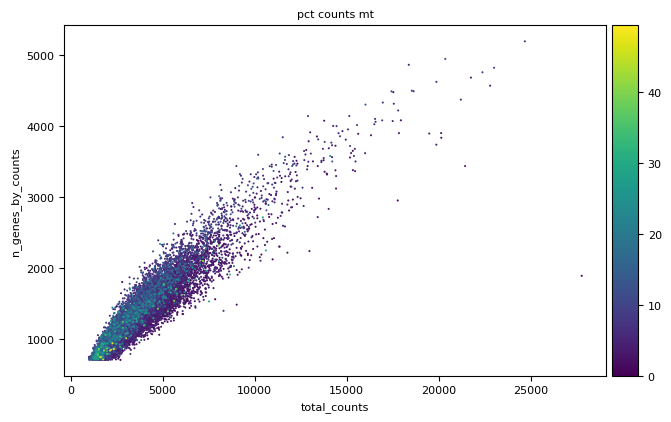

In [9]:
sc.pl.scatter(adata, "total_counts", "n_genes_by_counts", color="pct_counts_mt")

In [ ]:
#preprocessing
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 10, :].copy()

sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [ ]:
file_path_own ='/Users/lingting/Documents/GVHD_project/Paper_ready_pipeline/anndata_file/Tcells_sc_dc.h5ad'

adata_own = sc.read_h5ad(file_path_own)
adata_own= adata_own[adata_own.obs['decipher_clusters'].isin(["0",'1'])]

In [ ]:
adata_own.X.max()

In [ ]:
sc.pp.normalize_total(adata_own, target_sum=1e4)
sc.pp.log1p(adata_own)

In [ ]:
adata_own

In [ ]:
### This is from clustering
import anndata
Resi = anndata.read('/Users/lingting/Documents/GVHD_project/Paper_ready_pipeline/anndata_file/Resi.h5ad')

adata_own.obs['leiden_new_cluster_2'] =adata_own.obs['leiden_0.5']
adata_own.obs['leiden_new_cluster_2'] = adata_own.obs['leiden_new_cluster_2'].cat.add_categories(['Hobit+ CD8+ Resident Memory T cells'])
adata_own.obs.loc[adata_own.obs.index.isin(Resi[Resi.obs['leiden']=='1'].obs.index),'leiden_new_cluster_2'] = 'Hobit+ CD8+ Resident Memory T cells'
updated_colors = ['#1f77b4','#2ca02c','#e377c2','#FFA500',]
adata_own.uns['leiden_new_cluster_2_colors'] = updated_colors
colors = adata_own.uns['leiden_new_cluster_2_colors']

# Extract unique cluster labels from Tcell_sc_3_7000deg.obs['leiden_0.5']
unique_clusters = adata_own.obs['leiden_new_cluster_2'].cat.categories

# Create a mapping from cluster labels to colors
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, colors)}


In [ ]:
import pandas as pd
import scanpy as sc

#IBD
#https://www.frontiersin.org/journals/immunology/articles/10.3389/fimmu.2022.977117/full#h6

csv_path = '/Users/lingting/Documents/GVHD_project/FromJessie/GSM6443304_TFHS000025_annotation.csv'
matrix_path = '/Users/lingting/Documents/GVHD_project/FromJessie/GSM6443304_TFHS000025_matrix.mtx'
barcodes_path = '/Users/lingting/Documents/GVHD_project/FromJessie/GSM6443304_TFHS000025_barcodes.tsv.gz'
features_path = '/Users/lingting/Documents/GVHD_project/FromJessie/GSM6443304_TFHS000025_features.tsv'

# 1. Load the annotations CSV
adata2_annotations = pd.read_csv(csv_path)

# 2. Load the matrix file using scanpy and transpose it
adata2 = sc.read_mtx(matrix_path).T  # Transpose to have (n_cells, n_genes)


# 3. Load barcodes (cells)
adata2_barcodes = pd.read_csv(barcodes_path, header=None, compression='gzip', sep='\t')

# 4. Load features (genes)
adata2_features = pd.read_csv(features_path, header=None, sep='\t')

# 5. Set obs_names (cell barcodes) and var_names (gene names)
adata2.obs_names = adata2_barcodes[0].astype(str).values  # Ensure barcodes are strings
adata2.var_names = adata2_features[1].astype(str).values  # Ensure features are strings

adata2.var_names_make_unique()

#works above
adata2_annotations['extracted_barcode'] = adata2_annotations['barcode'].str.split('_', n=1).str[1]

# Get the barcodes from the annotations
annotation_barcodes = adata2_annotations['extracted_barcode'].values

# Create a boolean mask to filter the AnnData object
mask = adata2.obs_names.isin(annotation_barcodes)

# Filter the AnnData object to keep only rows (cells) that match the barcodes in annotations
adata2_filtered = adata2[mask].copy()  # Keep only matching rows

# Update obs_names for the filtered data
adata2_filtered.obs_names = adata2.obs_names[mask]

# Now, filter annotations to match the barcodes in the filtered matrix
# We will keep only the rows in annotations that match the filtered barcodes
filtered_annotations = adata2_annotations[adata2_annotations['extracted_barcode'].isin(adata2_filtered.obs_names)]

# Reset the index of the filtered annotations for proper alignment
filtered_annotations.reset_index(drop=True, inplace=True)

# Assign the filtered annotations to the filtered AnnData object
adata2_filtered.obs = filtered_annotations

# Final checks
print("Original number of cells:", adata2.n_obs)
print("Filtered number of cells:", adata2_filtered.n_obs)
print(adata2_filtered)

# If you want to keep the filtered adata2 as your main object
adata2 = adata2_filtered

print(adata2.X.max())
#preprocessing
sc.pp.filter_cells(adata2, min_genes=200)
sc.pp.filter_genes(adata2, min_cells=3)

sc.pp.normalize_total(adata2, target_sum=1e4)
sc.pp.log1p(adata2)

In [ ]:
adata_own.obs['leiden_0.5'].unique()

In [ ]:
adata_own.obs['leiden_new_cluster_2'].unique()

In [ ]:
# Ensure the cell barcodes are the index of .obs
adata_own.obs['leiden_overall'] = adata_own.obs['leiden_0.5'].astype(str)  # Convert to string to avoid Categorical issues
adata_own.obs['leiden_new_cluster_2'] = adata_own.obs['leiden_new_cluster_2'].astype(str)


In [ ]:
cd4_annotations = ['CD4+ Effector Memory', 'Naive CD4+ T-cell']
adata2_Novershtern_cd4 = adata2[adata2.obs['cluster_anno_NovershternPanel'].isin(cd4_annotations)]

# Filter for CD8 annotations (Activated CD8 T, SELL+ CD8 T, gdT cells)
cd8_annotations = ['CD8+ Effector Memory', 'Naive CD8+ T-cell']
adata2_Novershtern_cd8 = adata2[adata2.obs['cluster_anno_NovershternPanel'].isin(cd8_annotations)]


In [ ]:
cd4_annotations = ['CD4 TCM', 'CD4 TEM','Treg','CD4 Naive']
adata2_azimuth_cd4 = adata2[adata2.obs['cell_anno_azimuth'].isin(cd4_annotations)]

# Filter for CD8 annotations (Activated CD8 T, SELL+ CD8 T, gdT cells)
cd8_annotations = ['CD8 TEM', 'CD8 Naive', 'CD8 TCM']
adata2_azimuth_cd8 = adata2[adata2.obs['cell_anno_azimuth'].isin(cd8_annotations)]


In [ ]:
cd4_annotations = ['Activated CD4 T', 'Treg', 'SELL+ CD4 T', 'Th17']
adata_cd4 = adata[adata.obs['annotation'].isin(cd4_annotations)]

# Filter for CD8 annotations (Activated CD8 T, SELL+ CD8 T, gdT cells)
cd8_annotations = ['Activated CD8 T', 'SELL+ CD8 T', 'TRGV5/7 gdT', 'gdT', 'CD8 Tem', 'TRGV4 gdT', 'TRGV2 gdT']
adata_cd8 = adata[adata.obs['annotation'].isin(cd8_annotations)]


In [ ]:
adata_own.obs['leiden_new_cluster_2'] = adata_own.obs['leiden_new_cluster_2'].replace({
    'CD4+ Central Memory': 'CD4+ Central Memory T Cells',
    'Effector CD4+ T-cells': 'CD4+ Effector T Cells',
    'T-regs': 'CD4+ Regulatory T Cells',
    'Infiltrating activated cytotoxic T-cells': 'CD8+ Effector T Cells',
    'Resident CD8+ T-cells': 'CD8+ Tissue Resident Memory T Cells',
    'Proliferating CD8+ T-cells': 'CD8+ Proliferating T Cells',
    'Activated Unconventional CD8+ T-cells': 'CD8+ Cytotoxic Unconventional T Cells',
    'Homeostatic unconventional CD8+ T cells': 'CD8+ Homeostatic Unconventional T Cells'
})

# Define the updated annotation lists
cd4_annotations = ['CD4+ Central Memory T Cells', 'CD4+ Effector T Cells', 'CD4+ Regulatory T Cells']
cd8_annotations = [
    'CD8+ Effector T Cells', 'CD8+ Tissue Resident Memory T Cells', 
    'CD8+ Proliferating T Cells', 'CD8+ Cytotoxic Unconventional T Cells', 'CD8+ Homeostatic Unconventional T Cells', 'Hobit+ CD8+ Resident Memory T cells'
]

# Filter for CD4 annotations
adata_own_cd4 = adata_own[adata_own.obs['leiden_new_cluster_2'].isin(cd4_annotations)]

# Filter for CD8 annotations
adata_own_cd8 = adata_own[adata_own.obs['leiden_new_cluster_2'].isin(cd8_annotations)]




In [ ]:
adata_own_cd4.obs['leiden_new_cluster_2'].value_counts()

In [ ]:
adata_own_cd8.obs['leiden_new_cluster_2'].value_counts()

In [ ]:
model_cd4 = celltypist.train(adata_own_cd4, labels = 'leiden_new_cluster_2', n_jobs = 10, feature_selection = True)

In [ ]:
model_cd8 = celltypist.train(adata_own_cd8, labels = 'leiden_new_cluster_2', n_jobs = 10, feature_selection = True)

In [ ]:
model_cd4.write('/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd4.pkl')
model_cd4 = models.Model.load('/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd4.pkl')
predictions_cd4 = celltypist.annotate(adata_cd4, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd4.pkl', majority_voting = False)
adata_predictions_cd4 = predictions_cd4.to_adata()

In [ ]:
import matplotlib as mpl
mpl.rcParams['image.cmap'] = 'viridis'  # Or your preferred colormap
mpl.rcParams.update({'font.size': 8, 'svg.fonttype': 'none'})
mpl.rcParams['axes.titlesize'] = 8
mpl.rcParams['xtick.labelsize'] = 8  # Colorbar tick label size 
mpl.rcParams['ytick.labelsize'] = 8  # Colorbar tick label size

celltypist.dotplot(predictions_cd4, use_as_reference='annotation', use_as_prediction='predicted_labels', cmap='Reds', save = "cd4_gutatlas.png")
celltypist.dotplot(predictions_cd4, use_as_reference='annotation', use_as_prediction='predicted_labels', cmap='Reds', save = "cd4_gutatlas.svg")
celltypist.dotplot(predictions_cd4, use_as_reference='annotation', use_as_prediction='predicted_labels', cmap='Reds', save = "cd4_gutatlas.pdf")


In [ ]:
predictions_cd4 = celltypist.annotate(adata2_azimuth_cd4, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd4.pkl', majority_voting = False)
adata_predictions_cd4 = predictions_cd4.to_adata()

celltypist.dotplot(predictions_cd4, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_azimuth.png") 


celltypist.dotplot(predictions_cd4, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_azimuth.pdf") 



celltypist.dotplot(predictions_cd4, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_azimuth.svg") 

In [ ]:
predictions_cd4 = celltypist.annotate(adata2_Novershtern_cd4, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd4.pkl', majority_voting = False)
adata_predictions_cd4 = predictions_cd4.to_adata()
celltypist.dotplot(predictions_cd4, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_novershtern.png") 
celltypist.dotplot(predictions_cd4, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_novershtern.pdf") 
celltypist.dotplot(predictions_cd4, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd4_novershtern.svg") 

In [ ]:
model_cd8.write('/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd8.pkl')
model_cd8 = models.Model.load('/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd8.pkl')
predictions_cd8 = celltypist.annotate(adata_cd8, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd8.pkl', majority_voting = False)
adata_predictions_cd8 = predictions_cd8.to_adata()

celltypist.dotplot(predictions_cd8, use_as_reference = 'annotation', use_as_prediction = 'predicted_labels',cmap='Reds') 

In [ ]:
import umap
sc.pp.neighbors(adata_predictions_cd8)
sc.tl.umap(adata_predictions_cd8)
sc.pl.umap(adata_predictions_cd8, color = ['annotation', 'predicted_labels'], legend_loc = 'on data')

In [ ]:
import umap
sc.pp.neighbors(adata_own)
sc.tl.umap(adata_own)
sc.pl.umap(
    adata_own,
    color=['leiden_new_cluster_2'],
    legend_loc='right margin',
    legend_fontsize=10  # Adjust the font size (e.g., 10 for smaller fonts)
)

In [ ]:
adata_predictions_cd8.obs['predicted_labels'].value_counts()


In [ ]:
import pandas as pd

# Example: Access the predicted_labels DataFrame
predicted_labels = predictions_cd8.predicted_labels

# Get the existing categories from adata_own_cd8.obs['leiden_overall']
existing_categories = adata_own_cd8.obs['leiden_new_cluster_2'].unique()

# Ensure the predicted_labels column is categorical
if not pd.api.types.is_categorical_dtype(predicted_labels['predicted_labels']):
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].astype('category')

# Identify categories in adata_own_cd8.obs['leiden_overall'] that are not already in predicted_labels
missing_categories = [category for category in existing_categories if category not in predicted_labels['predicted_labels'].cat.categories]

# Add the missing categories to the predicted_labels column
if missing_categories:
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.add_categories(missing_categories)

# Maintain the original order of categories (existing + new)
all_categories_in_order = list(existing_categories)  # Use existing categories' order
predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.set_categories(all_categories_in_order, ordered=True)

# Now, assign each missing category to a different row sequentially
for i, new_category in enumerate(missing_categories):
    # Assign the missing category to the i-th row
    predicted_labels.loc[predicted_labels.index[i], 'predicted_labels'] = new_category

# Verify the updated DataFrame
print(f"Added categories: {missing_categories}")
print(predicted_labels['predicted_labels'].cat.categories)  # Show the updated categories
print(predicted_labels.head())  # Check the first few rows
print(predicted_labels['predicted_labels'].unique())  # Verify the unique categories


In [ ]:
celltypist.dotplot(predictions_cd8, use_as_reference = 'annotation', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_gutatlas.png")
celltypist.dotplot(predictions_cd8, use_as_reference = 'annotation', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_gutatlas.pdf")
celltypist.dotplot(predictions_cd8, use_as_reference = 'annotation', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_gutatlas.svg")

In [ ]:
predictions_cd8 = celltypist.annotate(adata2_azimuth_cd8, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd8.pkl', majority_voting = False)
adata_predictions_cd8 = predictions_cd8.to_adata()
celltypist.dotplot(predictions_cd8, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds') 

In [ ]:
import pandas as pd

# Example: Access the predicted_labels DataFrame
predicted_labels = predictions_cd8.predicted_labels

# Get the existing categories from adata_own_cd8.obs['leiden_overall']
existing_categories = adata_own_cd8.obs['leiden_new_cluster_2'].unique()

# Ensure the predicted_labels column is categorical
if not pd.api.types.is_categorical_dtype(predicted_labels['predicted_labels']):
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].astype('category')

# Identify categories in adata_own_cd8.obs['leiden_overall'] that are not already in predicted_labels
missing_categories = [category for category in existing_categories if category not in predicted_labels['predicted_labels'].cat.categories]

# Add the missing categories to the predicted_labels column
if missing_categories:
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.add_categories(missing_categories)

# Maintain the original order of categories (existing + new)
all_categories_in_order = list(existing_categories)  # Use existing categories' order
predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.set_categories(all_categories_in_order, ordered=True)

# Now, assign each missing category to a different row sequentially
for i, new_category in enumerate(missing_categories):
    # Assign the missing category to the i-th row
    predicted_labels.loc[predicted_labels.index[i], 'predicted_labels'] = new_category

# Verify the updated DataFrame
print(f"Added categories: {missing_categories}")
print(predicted_labels['predicted_labels'].cat.categories)  # Show the updated categories
print(predicted_labels.head())  # Check the first few rows
print(predicted_labels['predicted_labels'].unique())  # Verify the unique categories


In [ ]:
celltypist.dotplot(predictions_cd8, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_azimuth.png") 
celltypist.dotplot(predictions_cd8, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_azimuth.pdf") 
celltypist.dotplot(predictions_cd8, use_as_reference = 'cell_anno_azimuth', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_azimuth.svg") 

In [ ]:
predictions_cd8 = celltypist.annotate(adata2_Novershtern_cd8, model = '/Users/lingting/Documents/GVHD_project/FromJessie/model_from_own_cd8.pkl', majority_voting = False)
adata_predictions_cd8 = predictions_cd8.to_adata()
celltypist.dotplot(predictions_cd8, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds') 

In [ ]:
import pandas as pd

# Example: Access the predicted_labels DataFrame
predicted_labels = predictions_cd8.predicted_labels

# Get the existing categories from adata_own_cd8.obs['leiden_overall']
existing_categories = adata_own_cd8.obs['leiden_new_cluster_2'].unique()

# Ensure the predicted_labels column is categorical
if not pd.api.types.is_categorical_dtype(predicted_labels['predicted_labels']):
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].astype('category')

# Identify categories in adata_own_cd8.obs['leiden_overall'] that are not already in predicted_labels
missing_categories = [category for category in existing_categories if category not in predicted_labels['predicted_labels'].cat.categories]

# Add the missing categories to the predicted_labels column
if missing_categories:
    predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.add_categories(missing_categories)

# Maintain the original order of categories (existing + new)
all_categories_in_order = list(existing_categories)  # Use existing categories' order
predicted_labels['predicted_labels'] = predicted_labels['predicted_labels'].cat.set_categories(all_categories_in_order, ordered=True)

# Now, assign each missing category to a different row sequentially
for i, new_category in enumerate(missing_categories):
    # Assign the missing category to the i-th row
    predicted_labels.loc[predicted_labels.index[i], 'predicted_labels'] = new_category

# Verify the updated DataFrame
print(f"Added categories: {missing_categories}")
print(predicted_labels['predicted_labels'].cat.categories)  # Show the updated categories
print(predicted_labels.head())  # Check the first few rows
print(predicted_labels['predicted_labels'].unique())  # Verify the unique categories


In [ ]:
celltypist.dotplot(predictions_cd8, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_novershtern.png") 
celltypist.dotplot(predictions_cd8, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_novershtern.pdf") 
celltypist.dotplot(predictions_cd8, use_as_reference = 'cluster_anno_NovershternPanel', use_as_prediction = 'predicted_labels',cmap='Reds', save = "cd8_novershtern.svg") 